In [5]:
# Do all imports for script. If this fails, you need to import more
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from jupyter_datatables import init_datatables_mode
from csv import DictReader
import logging
from os import listdir
from datetime import datetime
from sqlalchemy import create_engine
from sqlalchemy import Table, Column, Integer, String, DateTime, Date, MetaData, ForeignKey
from sqlalchemy.sql import text
from time import time
import hashlib
%matplotlib inline

def find_database():
    names = []
    for file in listdir():
        if file.startswith('ETC_Droid_DB_'):
            names.append(file)
    if len(names) == 0:
        time = datetime.now()
        return f'ETC_Droid_DB_{time.strftime("%Y%m%d%H%M%S")}.db'
    else:
        return names[-1]

print(f'Using database file: {find_database()}')
    
# Enable logging
handler = logging.FileHandler('sql.log')
handler.setLevel(logging.DEBUG)
logging.getLogger('sqlalchemy').addHandler(handler)

# Connect to the test.db sqlite database generated in the other file
engine = create_engine(f"sqlite:///{find_database()}", echo=False)
conn = engine.connect()

Using database file: ETC_Droid_DB_20210726130527.db


In [6]:
def output_as_markdown_table(headers, values, center=True):
    # Get the amount of padding to add
    sizes = []
    for header in headers:
        sizes.append(len(header))
    for row in values:
        for index, value in enumerate(row):
            sizes[index] = max(sizes[index], len(str(value)))
    
    # Print the headers
    print('|', end='')
    for index, header in enumerate(headers):
        if center:
            print(f' {str(header).center(sizes[index])} |', end='')
        else:
            print(f' {str(header).ljust(sizes[index])} |', end='')
    print()
    
    # Print the separation row
    print('|', end='')
    for size in sizes:
        string = ''
        for x in range(size):
            string += '-'
        print(f' {string} |', end='')
    print()
    
    # Print the values
    for row in values:
        print('|', end='')
        for index, value in enumerate(row):
            if center:
                print(f' {str(value).center(sizes[index])} |', end='')
            else:
                print(f' {str(value).ljust(sizes[index])} |', end='')
        print()


def SequenceBuilder(listA):
    length = len(listA)
    sequence = []
    for i in range(length):
        sequence.append(i)
    return sequence


def queryTable(headers,values):
    sequence = SequenceBuilder(headers)
    #plt.rcParams['figure.figsize'] = [20, 2]
    #plt.rcParams['figure.dpi'] = 900
    fig, ax = plt.subplots(1,1)
    ax.axis('off')

    table = ax.table(cellText=values,
                     colLabels=headers,
                     cellLoc='left',
                     rowLoc='center',
                     loc="center")

    table.scale(1,2)
    table.auto_set_column_width(sequence)

    plt.show()

## 'droid_ids' Table Contents
Droid profile output, ids are tied to unique files
### Header Information
1.  'id' -- A unqiue id number identifying this specific file
2.  'parent_id' -- The unqiue id number of the parent folder
3.  'uri' -- A uri that directs to the semester relative file location. Ex: file://2008_semester_1/wiixercise/file.zip
4.  'file_path' -- The semester relative path of this file. Ex.: /2008_semester_1/wiixercise/file.zip
5.  'filename' -- The name of this file inclusing the extension: file.zip
6.  'id_method' -- The method that was used to identify the file_format_name. Extension, Container or Signature
7.  'status' -- The status of the scanning of this file and its children. Done or Empty
8.  'size' -- The size of this file in bytes. If folder, then the size is blank
9.  'type' -- The type of item. File or Folder
10. 'file_extension' -- The file exenstion of the file. Blank for a folder
11. 'last_modified' -- The modification time of the file or folder
12. 'ext_mis_warning' -- True if a file extension does not match the binary signature of the file. False otherwise
13. 'hash' -- The sha256 hash of the file
14. 'file_format_count' -- The count of attached file format matches
15. 'project_name' -- The name of the project from ETC Past Projects Listing file. Will start with 'Unverified Name:' if a match could not be found.

## 'droid_formats' Table Contents
1. 'id' -- A unqiue id that identifies this specific format
2. 'file_id' -- The if of the file that this format belongs to.
3. 'pronom_id' -- PRONOM fmt number
4. 'mime_type' -- The detected MIME type. Blank if not found.
5. 'file_format_name' -- PRONOM Identified File Format 
6. 'file_format_version' -- PRONOM Identified File Version

### (Stats 1) Total Amounts Related to Files

Current DB Hash (7/26/2021): c3c39eb0c842c852ee0517686d72772f

1. Total Files: 10,493,160
2. Total File Extensions: 4,982

Current DB Hash (7/22/2021): d3d9980c6153ef38f27ff46f9b2d356a

1. Total Files: 10,498,189
2. Total File Extensions: 4,982

Current DB Hash (7/20/2021): 5b838ed892dae08217083be9022ccd4e

1. Total Files: 10,498,189
2. Total File Extensions: 4,982

Current DB Hash (7/14/2021): 7e97ac65e748e1b0a5753bc95464a600 

1. Total Files: 10,444,003
2. Total File Extensions: 4,977

#### Current DB Hash Check

In [3]:
current_db_hash = "c3c39eb0c842c852ee0517686d72772f"

In [4]:
BLOCKSIZE = 65536
hasher = hashlib.md5()
with open(find_database(), 'rb') as afile:
    buf = afile.read(BLOCKSIZE)
    while len(buf) > 0:
        hasher.update(buf)
        buf = afile.read(BLOCKSIZE)

current_db_check_hash = hasher.hexdigest()
print(current_db_check_hash)

c3c39eb0c842c852ee0517686d72772f


In [5]:
if current_db_check_hash == current_db_hash:
    print("DB is current")
else:
    print("DB is not current")

DB is current


### Recreation of table 1 from original analysis. Top 20 extensions by count

In [7]:
query = 'select file_extension, file_format_name, file_format_version, count() from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where type="File" and file_format_name != "" group by file_extension, file_format_name, file_format_version order by count() desc limit 20'
table_headers = ['Extension', 'File Format', 'Format Version', 'Count']

Trying to execute query:
 select file_extension, file_format_name, file_format_version, count() from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where type="File" and file_format_name != "" group by file_extension, file_format_name, file_format_version order by count() desc limit 20


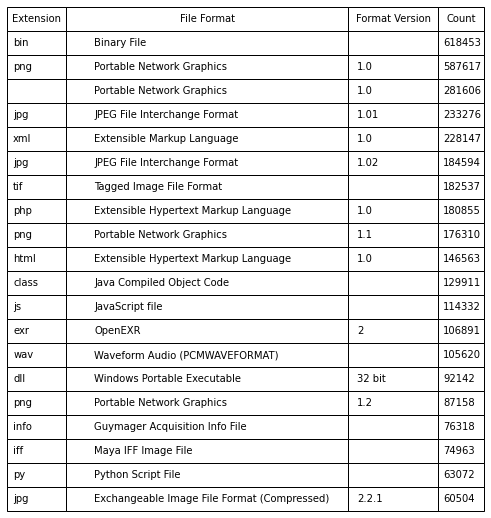

In [8]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)

### Recreation of table 2 from original analysis. Top 20 known file formats by aggregrate size

In [9]:
query = 'select file_format_name, file_format_version, round(sum(size) / 1073741824.0, 2) from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where type="File" and file_format_name != "" group by file_format_name, file_format_version order by sum(size) desc limit 20'
table_headers = ['File Format Name', 'Version', 'Size (GB)']

Trying to execute query:
 select file_format_name, file_format_version, round(sum(size) / 1073741824.0, 2) from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where type="File" and file_format_name != "" group by file_format_name, file_format_version order by sum(size) desc limit 20


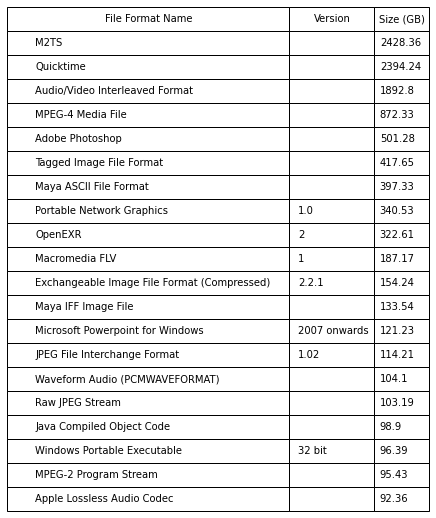

In [10]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)

### Total number of files

In [32]:
query = 'select count() from droid_ids where type = "File"'
table_headers = ['Total number of files']

Trying to execute query:
 select count() from droid_ids where type = "File"


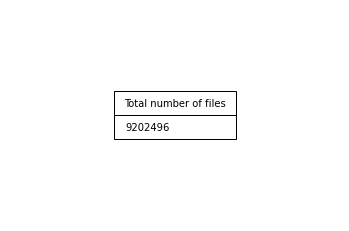

In [33]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)

In [16]:
query = 'select round(sum(size) / 1073741824.0, 2) from droid_ids'
table_headers = ['Total size of dataset (GB)']

Trying to execute query:
 select round(sum(size) / 1073741824.0, 2) from droid_ids


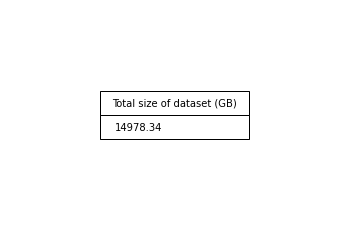

In [17]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)

In [20]:
query = 'select project_name, count() from droid_ids group by project_name order by count() desc limit 20'
table_headers = ['Project Name','Number of files per project']

Trying to execute query:
 select project_name, count() from droid_ids group by project_name order by count() desc limit 20


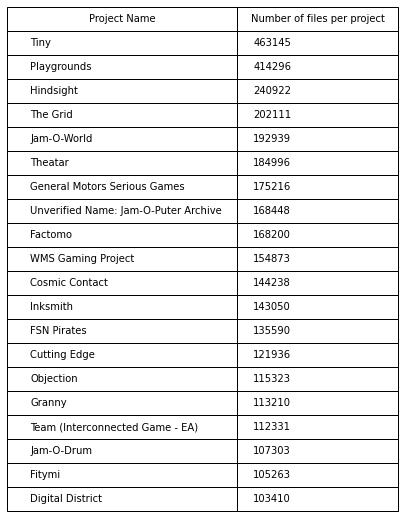

In [21]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)

In [26]:
query = 'select count(distinct droid_ids.id) from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where file_format_name != ""'
table_headers = ['Number of identified file formats']

Trying to execute query:
 select count(distinct droid_ids.id) from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where file_format_name != ""


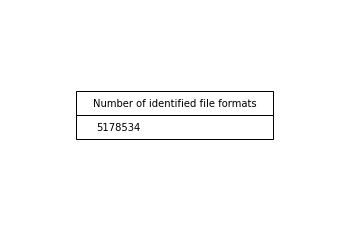

In [27]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)

In [50]:
query = 'select distinct mime_type from droid_formats'
table_headers = ['Distinct Mime types']

Trying to execute query:
 select distinct mime_type from droid_formats


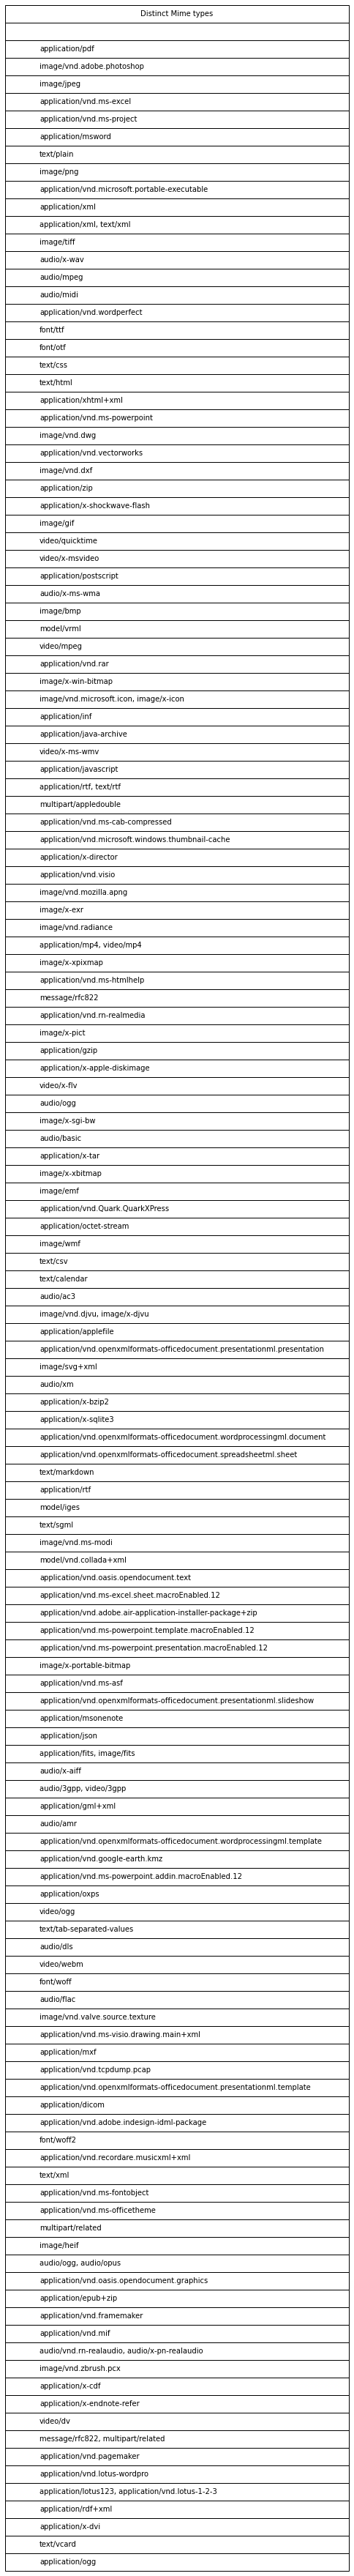

In [51]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)

In [30]:
query = 'select count(distinct file_extension) from droid_ids'
table_headers = ['Total number of discrete file extensions']

Trying to execute query:
 select count(distinct file_extension) from droid_ids


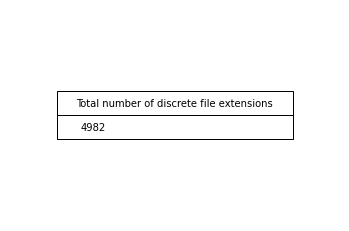

In [31]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)

In [56]:
identified = 'select count(distinct droid_ids.id) from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where type = "File" and file_format_name != ""'
total = 'select count(droid_ids.id) from droid_ids where type="File"'
table_headers = ['Ratio of file extensions identified to total file extensions']

In [57]:
#print('Trying to execute query:\n', query, flush=True)
identified = conn.execute(text(identified)).fetchall()
total = conn.execute(text(total)).fetchall()

[[5160117], [9202496]]


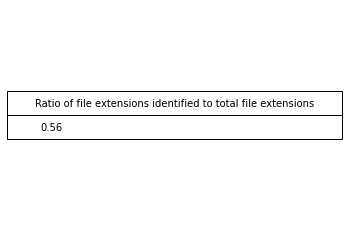

In [57]:
table_values = []
for line in identified:
    table_values.append(list(line))
    

for line in total:
    table_values.append(list(line))
print(table_values)
queryTable(table_headers, [[round(int(table_values[0][0])/int(table_values[1][0]),2)]])

In [80]:
query = 'select count(distinct droid_ids.id) from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where type = "File" and file_format_name = ""'
table_headers = ['Number of unidentified files extensions']

Trying to execute query:
 select count(distinct droid_ids.id) from droid_ids join droid_formats on droid_ids.id=droid_formats.file_id where type = "File" and file_format_name = ""


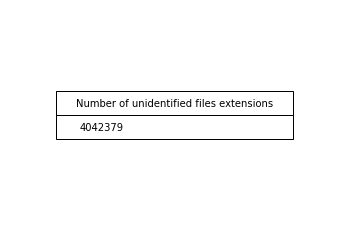

In [81]:
print('Trying to execute query:\n', query, flush=True)
result = conn.execute(text(query)).fetchall()
table_values = []
for line in result:
    table_values.append(list(line))

queryTable(table_headers, table_values)